# Aigerim Gilmanova 

#### Sensors and Sensing 
#### Home  Work 2
#### 14 November, 2021

# Task 1 (Case 2)

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Reading the data from the desktop. It is necessary to write the path of the file. 
df = pd.read_table('C:\\Users\\Acer\\Desktop\\case2.txt') 

In [3]:
# The data in provided file is in one column, so it is necessary to split them into two columns, 
# which are "Time" and "Roll Angle". 
# Then, data from string type was converted into float type.
df['Time'].str.split(',', expand=True)
df[['Time', 'Roll Angle']] = df['Time'].str.split(',', expand=True)
df[['Time', 'Roll Angle']] = df[['Time', 'Roll Angle']].astype(float)

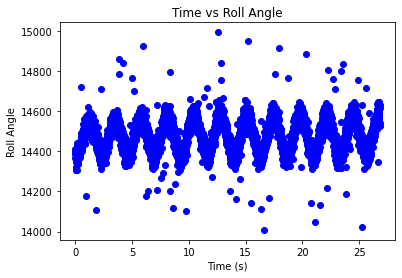

In [4]:
# Plotting data to observe data and its shape of distribution.
plt.plot(df['Time'], df['Roll Angle'], 'bo')
plt.title('Time vs Roll Angle')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle')
plt.show()

In [5]:
N = np.shape(df['Roll Angle'])[0] # N is a number of observations which are 6700
K = np.zeros(N) # K is a matrix of Kalman filter which is going to be evaluated
var = 17 # variable 'var' is a squared sigma whic is set to 17 as a assumption

In [6]:
# Defining mean and variance of Roll Angles
angle_mean = np.mean(df['Roll Angle']) 
opt_angle = np.zeros(N) 
opt_angle[0] = df['Roll Angle'][0]

angle_var = np.var(df['Roll Angle'])
opt_var = np.zeros(N)
opt_var[0] = np.sqrt(angle_var)

6272.138453530855


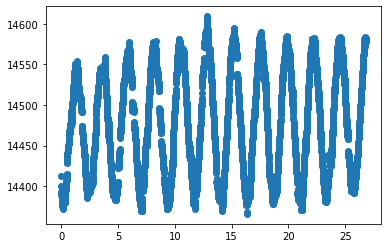

In [7]:
# Kalman filter 
for i in range(1, N):
    opt_var[i] = np.sqrt(angle_var*(opt_var[i-1]**2+var)/(angle_var+opt_var[i-1]**2+var))
    K[i] = (opt_var[i]**2)/angle_var
    opt_angle[i] = (opt_angle[i-1])*(1-K[i])+K[i]*df['Roll Angle'][i]    
mean = np.min(opt_angle)
print(angle_var)
plt.scatter(df['Time'], opt_angle) 

In [8]:
# Stabilized Kalman filter. At some point K variable stop changing and stabilizes. 
# 1000 is an assumption, but after 6700 iterations K also stabilizes.
K_stab = K[1000]
print('Stabilized Kalman coefficient is ' + f'{K_stab}')

Stabilized Kalman coefficient is 0.05072393163536172


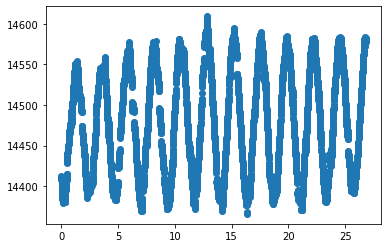

In [9]:
# Using stabilized Kalman constant
opt_angle1 = np.zeros(N)
K_stab = 0.0507 
opt_angle1[0] = df['Roll Angle'][0]
for i in range(1, N):
    opt_angle1[i] = (opt_angle1[i-1])*(1-K_stab)+K_stab*df['Roll Angle'][i]
plt.scatter(df['Time'], opt_angle1)

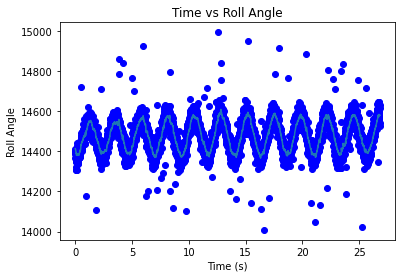

In [10]:
# Plotting initial graph with Kalman filter.
plt.plot(df['Time'], df['Roll Angle'], 'bo')
#plt.plot(df['Time'], opt_angle)
plt.plot(df['Time'], opt_angle1)
plt.title('Time vs Roll Angle')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle')
plt.show()

Reference for Kalman filter https://david.wf/kalmanfilter/

# Task 2 

## Calibrating camera

In [17]:
a = 10 # number of inside corners along x-axis
b = 7 # number of inside corners along y-axis
l = 25 # standart length (mm) of chess box

In [18]:
# Termination criteria to generate necessary structure
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
criteria

(3, 30, 0.001)

In [19]:
# Defining matrices that will be used further 
objp = np.zeros((b*a, 3), np.float32)
objp[:, :2] = np.mgrid[0:a, 0:b].T.reshape(-1, 2)

# defining lists for 3d (world image), 2d (plane image) points and images.
objpoints = [] 
imgpoints = [] 
images = []

In [23]:
# Appending lists. 
for i in range (1,32):
    image = cv2.imread(f'chessboard/p ({i}).jpg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(gray) # Appending images list of gray converted images to extract feautures.  
    
    # Finding chess board corners.
    ret, corners = cv2.findChessboardCorners(gray, (a, b), None)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (9, 9), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Defining images matrices with its corners.
        image = cv2.drawChessboardCorners(image, (a, b), corners2, ret)

(720, 1280)

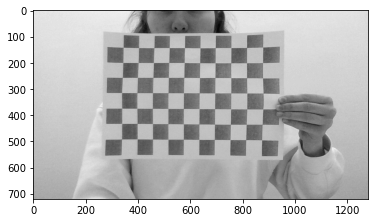

In [25]:
# One of the images
plt.imshow(images[1], cmap='gray')
images[1].shape

In [26]:
# Making calibration, where mtx is an output 3x3 floating-point camera matrix,
# dist is an output vector of distortion coefficients,
# rvecs - output of rotation vectors and tvecs - output of translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Store the parameters 
np.savez('Parameters', ret=ret, matrix=mtx, distance=dist, rotation=rvecs, translation=tvecs)


In [29]:
# Image shape. Height and width
h, w = img.shape[:2]

In [31]:
# Returns the new (optimal) camera matrix based on the free scaling parameter.
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

In [32]:
# Making undistortion and cropping the image
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

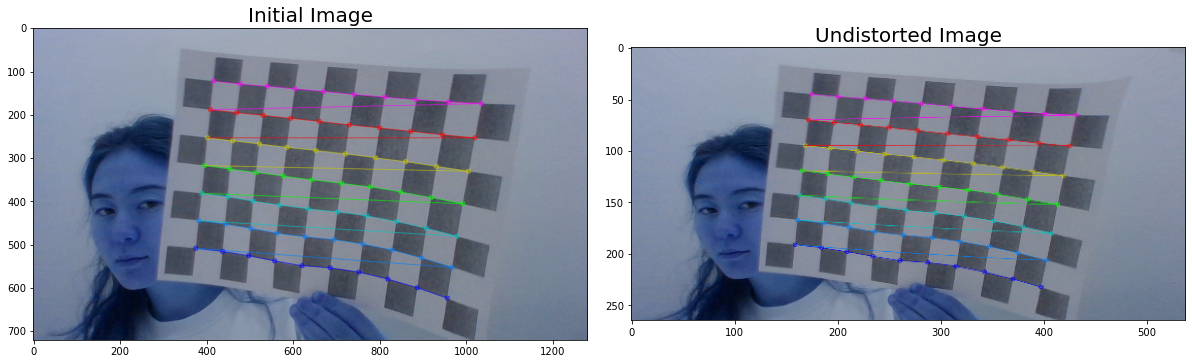

In [34]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Initial Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [36]:
# Measuring error of projection
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error

print("The error = %.2f \n" % (tot_error/len(objpoints)))

The error = 0.34 



## Measuring object size

In [37]:
obj = cv2.imread('obj.jpg')
h, w = obj.shape[:2]

In [38]:
# Undistort the image and cropping the image
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
dst = cv2.undistort(obj, mtx, dist, None, newcameramtx)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
obj = dst

In [39]:
# Calculation of the ratio
gray = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
# Find the chess board corners of photo
ret, corners = cv2.findChessboardCorners(gray, (a, b), None)
corners2 = cv2.cornerSubPix(gray, corners, (9, 9), (-1, -1), criteria)
# Draw and display the corners
image_corn = cv2.drawChessboardCorners(obj, (a, b), corners2, ret)

In [40]:
# Finding the chess box diagonal, ration of pixels to mm and measuring focal length (f)
xy = corners[11][0]-corners[0][0]
x = xy[0]
y = xy[1]
ratio_x = x/l
ratio_y = y/l
ratio = (ratio_x+ratio_y)/2
f = (0.5*(mtx[0][0]+mtx[1][1]))/ratio

In [41]:
# To find an object (phone) it is necessary to convert color from BGR to HSV
hsv_img = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
#Estimate the range of the object color 
COLOR_MIN = np.array([100, 0, 0], np.uint8)
COLOR_MAX = np.array([130, 255, 255], np.uint8)
frame_threshed = cv2.inRange(hsv_img, COLOR_MIN, COLOR_MAX)
imgray = frame_threshed
ret, thresh = cv2.threshold(frame_threshed, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [42]:
# Finding the index of the largest contour.
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(obj, (x, y), (x+w, y+h), (0, 255, 0), 2)

array([[[149, 157, 157],
        [144, 153, 156],
        [143, 152, 155],
        ...,
        [144, 150, 149],
        [143, 149, 148],
        [145, 152, 149]],

       [[148, 156, 156],
        [145, 154, 157],
        [144, 153, 156],
        ...,
        [142, 147, 147],
        [148, 154, 153],
        [146, 152, 151]],

       [[148, 156, 158],
        [146, 155, 158],
        [145, 154, 157],
        ...,
        [145, 150, 151],
        [148, 154, 153],
        [146, 152, 151]],

       ...,

       [[ 39, 136, 160],
        [ 39, 135, 158],
        [ 40, 134, 157],
        ...,
        [  0,  90, 176],
        [  1,  92, 182],
        [  1,  94, 186]],

       [[ 39, 134, 157],
        [ 37, 133, 156],
        [ 38, 135, 158],
        ...,
        [  8,  95, 178],
        [  3,  91, 175],
        [  1,  89, 175]],

       [[ 38, 136, 158],
        [ 37, 136, 158],
        [ 34, 135, 157],
        ...,
        [ 10,  96, 177],
        [ 10,  96, 178],
        [  8,  94, 177]]

Using the methods of finding contour and color to detect the object.

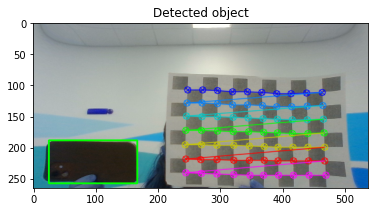

In [43]:
plt.imshow(obj, cmap='gray')
plt.title('Detected object')
plt.show()

In [45]:
# Measuring object real size.
distance = 70 # distance that is measured by the ruler.
width = distance*w/(ratio*f)
height = distance*h/(ratio*f)
print("Object width is %.2f cm" % width, "\nObject height is %.2f cm" % height)

Object width is 10.17 cm 
Object height is 4.94 cm


## Measuring the distance from the object to the camera

In [46]:
obj = cv2.imread('obj.jpg')
h,  w = obj.shape[:2]

In [47]:
# Undistort the image and cropping the image
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
dst = cv2.undistort(obj, mtx, dist, None, newcameramtx)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
obj = dst

In [48]:
# To find an object (phone) it is necessary to convert color from BGR to HSV
hsv_img = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
#Estimate the range of the object color 
COLOR_MIN = np.array([100, 0, 0], np.uint8)
COLOR_MAX = np.array([130, 255, 255], np.uint8)
frame_threshed = cv2.inRange(hsv_img, COLOR_MIN, COLOR_MAX)
imgray = frame_threshed
ret, thresh = cv2.threshold(frame_threshed, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [49]:
# Finding the index of the largest contour.
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(obj, (x, y), (x+w, y+h), (0, 255, 0), 2)

array([[[149, 157, 157],
        [144, 153, 156],
        [143, 152, 155],
        ...,
        [144, 150, 149],
        [143, 149, 148],
        [145, 152, 149]],

       [[148, 156, 156],
        [145, 154, 157],
        [144, 153, 156],
        ...,
        [142, 147, 147],
        [148, 154, 153],
        [146, 152, 151]],

       [[148, 156, 158],
        [146, 155, 158],
        [145, 154, 157],
        ...,
        [145, 150, 151],
        [148, 154, 153],
        [146, 152, 151]],

       ...,

       [[ 39, 136, 160],
        [ 39, 135, 158],
        [ 40, 134, 157],
        ...,
        [  0,  90, 176],
        [  1,  92, 182],
        [  1,  94, 186]],

       [[ 39, 134, 157],
        [ 37, 133, 156],
        [ 38, 135, 158],
        ...,
        [  8,  95, 178],
        [  3,  91, 175],
        [  1,  89, 175]],

       [[ 38, 136, 158],
        [ 37, 136, 158],
        [ 34, 135, 157],
        ...,
        [ 10,  96, 177],
        [ 10,  96, 178],
        [  8,  94, 177]]

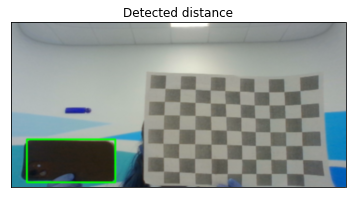

The detected distance is 70.11 cm


In [52]:
plt.imshow(obj, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title('Detected distance')
plt.show()
print("The detected distance is %.2f cm" % (height*mtx[1][1]/h))

The following references were used https://www.youtube.com/watch?v=US9p9CL9Ywg, https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html, https://www.pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/, https://www.pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/